# Analyze Data from MPI Experiment
This file can be used to calculate the Jensen-Shannon distance between the human and model distributions. Currently, this file uses results created from LLaMA (7b) and LLaMA Chat (7b). 

**The only change you need to make is the output directory in the first code box below "Import Results".**

In [1]:
# Import Results
# Change the directory to point to the results for your models
import torch
pre_model = torch.load("output/mpi/Mistral-7B-v0.2_mpi", map_location=torch.device('cpu'))
chat_model = torch.load("output/mpi/Mistral-7B-Instruct-v0.2_mpi", map_location=torch.device('cpu'))
our_model = torch.load('./output/mpi/janus_mpi',map_location=torch.device('cpu'))

/tmp/ipykernel_468061/4032015167.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre_model = torch.load("output/mpi/Mistral-7B-v0.2_mpi", map_location=torch.device('cpu'

In [2]:
#Import Human Data
import pandas as pd
# This takes a few minutes to download, it is a big file!
human_resp = pd.read_csv("./data/mpi_human_resp.csv").iloc[:, -120:]
key = pd.read_csv("./data/mpi_questions.csv", delimiter="\t")


In [3]:
# Need to remap some questions which were labelled backwards on the original survey
def remap_values(column, key_value):
    if key_value == 1:
        return column
    elif key_value == -1:
        mapping = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
        return column.map(mapping)
# Apply remapping function to each column in 'human_resp' DataFrame
for i,column in enumerate(human_resp.columns):
    key_value = key['key'][i]
    human_resp[column] = remap_values(human_resp[column], key_value)

In [4]:
# Calculate human distribution for each test
human_distr_df = {}
# Iterate over columns in the DataFrame
for i, column in enumerate(human_resp):
    # Get value counts for each column
    value_counts = human_resp[column].value_counts().to_list()
    # Calculate probability distribution by dividing by the sum
    total_values = sum(value_counts[1:]) # we ignore values of 0 = ppl who did not answer
    probability_distribution = {value / total_values for value in value_counts[1:]} # we ignore values of 0 = ppl who did not answer
    # Convert the probability distribution dictionary to a list of tuples
    probability_list = probability_distribution
    # Add the list to the dictionary with column name as key
    human_distr_df[i] = probability_list

In [5]:
# Calculate the Jensens-Shannon Distance
from scipy.spatial import distance
import numpy as np
import random
random.seed(1)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def calc_metrics(results_df):
    distance_model_human = []
    distance_model_shuffle_human = []
    entropy_human = []
    entropy_model = []
    for i, key in enumerate(list(results_df.keys())):
        human_dist = [x for x in human_distr_df[i]]
        model_dist = softmax([value["sum"] for key, value in results_df[key].items() if key != 'human_resp'][:len(human_dist)])
        model_dist_shuffle = random.sample(list(model_dist), len(model_dist))
        distance_model_human.append(distance.jensenshannon(human_dist, model_dist, 2.0))
        distance_model_shuffle_human.append(distance.jensenshannon(model_dist_shuffle, human_dist, 2.0))
        entropy_human.append(-np.sum(human_dist * np.log(human_dist))) 
        entropy_model.append(-np.sum(model_dist * np.log(model_dist)))
    return {"model_human": distance_model_human,
            "model_shuffle_human": distance_model_shuffle_human, 
            "entropy_human": entropy_human,
            "entropy_model": entropy_model}


In [6]:
# Calcuate Metrics on Pre/Post aligned models
# distance_df_pre_aligned = calc_metrics(pre_aligned_model)
distance_df_pre = calc_metrics(pre_model)
distance_df_chat = calc_metrics(chat_model)
distance_df_our = calc_metrics(our_model)

In [7]:
# Display Results
import numpy as np
print("Models vs. human")
print("Pre-trained")
print(np.nanmean(distance_df_pre['model_human']))
print("Chat")
print(np.nanmean(distance_df_chat['model_human']))
print("Our")
print(np.nanmean(distance_df_our['model_human']))
print(" ")

print("Models Shuffle vs. human")
print("Pre-trained")
print(np.nanmean(distance_df_pre['model_shuffle_human']))
print("Chat")
print(np.nanmean(distance_df_chat['model_shuffle_human']))
print("Our")
print(np.nanmean(distance_df_our['model_shuffle_human']))
print(" ")

print("Entropy: human")
print(np.nanmean(distance_df_pre['entropy_human']))
print("Entropy: Pre")
print(np.nanmean(distance_df_pre['entropy_model']))
print("Entropy: Chat")
print(np.nanmean(distance_df_chat['entropy_model']))
print("Entropy: Our")
print(np.nanmean(distance_df_our['entropy_model']))


Models vs. human
Pre-trained
0.2865497296403424
Chat
0.6181872304875715
Our
0.4852156489820658
 
Models Shuffle vs. human
Pre-trained
0.37425430351095923
Chat
0.6908831047895883
Our
0.586348160345321
 
Entropy: human
1.2289778770540807
Entropy: Pre
1.3334334
Entropy: Chat
0.32527268
Entropy: Our
0.64912415


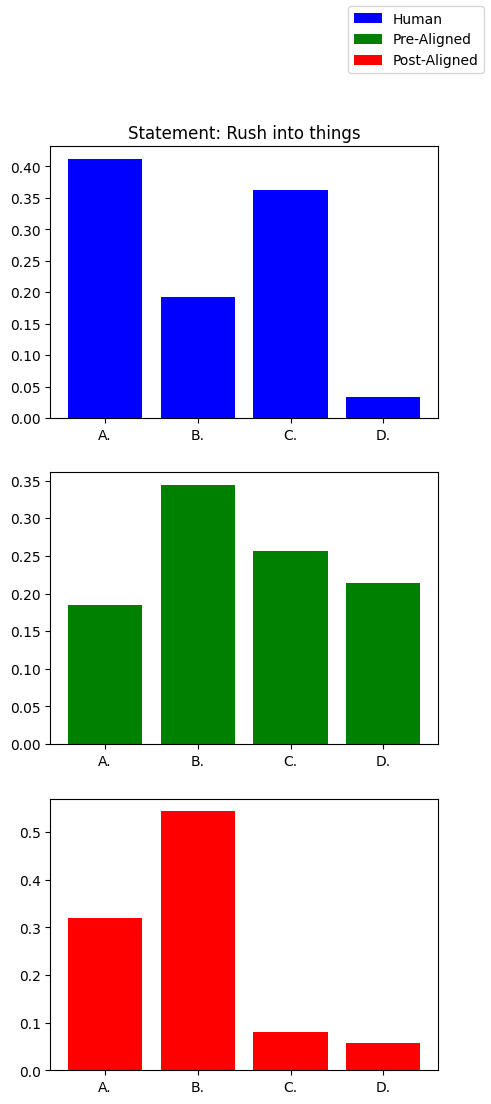

In [8]:
import matplotlib.pyplot as plt
key = 'Q89' # choose which question to view (Q0 - Q119)

human_dist = [x for x in human_distr_df[int(key[1])]]
model_dist = softmax([value["sum"] for key, value in pre_model[key].items() if key != 'human_resp'][:len(human_dist)])
model_dist_chat = softmax([value["sum"] for key, value in our_model[key].items() if key != 'human_resp'][:len(human_dist)])

fig, axs = plt.subplots(3,1, figsize=(5,12))
answer_labels = ["A.", "B.", "C.", "D.", "E."]

axs[0].set_title(f"Statement: {our_model[key]['A']['statement']}")
axs[0].bar(answer_labels[0:len(human_dist)],human_dist, label = "Human", color = "blue")
axs[1].bar(answer_labels[0:len(human_dist)],model_dist, label = "Pre-Aligned", color = "green")
axs[2].bar(answer_labels[0:len(human_dist)],model_dist_chat, label = "Post-Aligned", color = "red")

fig.legend()


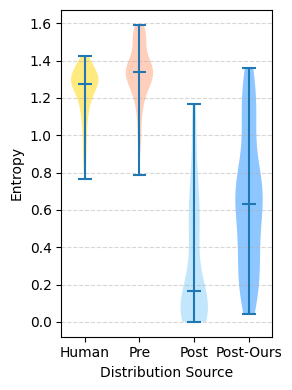

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming distance_df_pre, distance_df_chat, and distance_df_our are your existing DataFrames

# Prepare data
data = [
    distance_df_pre['entropy_human'],
    distance_df_pre['entropy_model'],
    distance_df_chat['entropy_model'],
    distance_df_our['entropy_model']
]

# Create the plot
fig, ax = plt.subplots(figsize=(3, 4))

# Create violin plot
violin_parts = ax.violinplot(data, showmeans=False, showmedians=True)

# Customize violin parts
violin_parts['bodies'][0].set_alpha(0.5) 
violin_parts['bodies'][0].set_facecolor('gold') 
violin_parts['bodies'][1].set_alpha(0.5) 
violin_parts['bodies'][1].set_facecolor('lightsalmon') 
violin_parts['bodies'][2].set_alpha(0.5) 
violin_parts['bodies'][2].set_facecolor('lightskyblue') 
violin_parts['bodies'][3].set_alpha(0.5) 
violin_parts['bodies'][3].set_facecolor('dodgerblue') 
# violin_parts['bodies'][1].set_facecolor('turquoise')
# for pc in violin_parts['bodies']:
#     pc.set_alpha(0.7)

# for partname in ('cbars','cmins','cmaxes','cmedians'):
#     vp = violin_parts[partname]
#     vp.set_edgecolor('black')
#     vp.set_linewidth(1)

# Set x-axis labels
ax.set_xticks([1, 2, 3, 4], )
ax.set_xticklabels(['Human', 'Pre', 'Post', 'Post-Ours'])
# ax.tick_params(axis='x', rotation=90)

# Customize the plot
# ax.set_title('Distribution of Entropy Scores Across Models')
ax.set_xlabel('Distribution Source')
ax.set_ylabel('Entropy')

# Add a grid for better readability
ax.yaxis.grid(True, alpha=0.5, linestyle='--')

# Show the plot
plt.tight_layout()
plt.savefig('output/mpi/entropy_mpi.pdf', format='pdf')
plt.show()